<a href="https://colab.research.google.com/github/poojamahajan0712/Data-Science-Portfolio/blob/main/NLP/Machine%20Translation/MachineTranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install "tensorflow-text>=2.11"

<h2> English to French Translation ( Neural Machine Translation with Attention ) </h2>

<h4> Loading required libraries</h4>

In [4]:
import tensorflow as tf
# import tensorflow_text as tf_text
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense, Embedding, TimeDistributed, MultiHeadAttention, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Model,load_model, model_from_json


import pickle as pkl
import unicodedata
import re
import pathlib
from collections import Counter
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


# setting the working directory
os.chdir('/content/drive/MyDrive/Machine_Translation')

from models.model1 import *
from models.util import *




<h4> Load Data </h4>

In [5]:
dataset_path = "/content/drive/MyDrive/Machine_Translation/eng_-french/eng_-french.csv"
df1 = pd.read_csv(dataset_path)
df1.tail()

,English words/sentences,French words/sentences
175616,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç..."
175617,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
175618,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
175619,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
175620,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...


In [6]:
df1.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [7]:
eng_text = df1['English words/sentences'].values
french_text = df1['French words/sentences'].values

In [6]:
eng_text[1],french_text[1] ## space before ! is encoded as \u202f

('Run!', 'Cours\u202f!')

<h4> Data Preprocessing </h4>

In [8]:
eng_processed = [lower_and_split_punct(sentence) for sentence in eng_text]
french_processed = [lower_and_split_punct(sentence) for sentence in french_text]

In [9]:
eng_processed[0],eng_text[0],french_processed[0],french_text[0]


('[START] hi . [END]', 'Hi.', '[START] salut ! [END]', 'Salut!')

<h4> Data Preparation for Model Building </h4>

In [10]:
X = eng_processed
Y = french_processed
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1)
len(X_train),len(y_train), len(X_test), len(y_test)

(158058, 158058, 17563, 17563)

In [11]:
X_train[0], y_train[0]

('[START] i can drive a car . [END]',
 '[START] je peux conduire une voiture . [END]')

In [12]:
#Training data
max_length_english = Max_length(X_train)
max_length_french= Max_length(y_train)

#Test data
max_length_english_test = Max_length(X_test)
max_length_french_test = Max_length(y_test)

In [13]:
max_length_english,max_length_french,max_length_english_test,max_length_french_test

(53, 64, 44, 52)

In [14]:
## Creating english tokeniser and padding the sequences upto maxlength
englishTokenizer = Tokenizer()
englishTokenizer.fit_on_texts(X_train)
Eword2index = englishTokenizer.word_index
vocab_size_source = len(Eword2index) + 1

X_train = englishTokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length_english, padding='post')

X_test = englishTokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_length_english, padding='post')

In [15]:
## Creating French tokeniser and padding the sequences upto maxlength
frenchTokenizer = Tokenizer()
frenchTokenizer.fit_on_texts(y_train)
Fword2index = frenchTokenizer.word_index
vocab_size_target = len(Fword2index) + 1

y_train = frenchTokenizer.texts_to_sequences(y_train)
y_train = pad_sequences(y_train, maxlen=max_length_french, padding='post')

y_test = frenchTokenizer.texts_to_sequences(y_test)
y_test = pad_sequences(y_test, maxlen = max_length_french_test, padding='post')

In [ ]:
## saving for future use

# with open('data_pkl/NMT_data.pkl','wb') as f:
#   pkl.dump([X_train, y_train, X_test, y_test],f)

# with open('data_pkl/NMT_Etokenizer.pkl','wb') as f:
#   pkl.dump([vocab_size_source, Eword2index, englishTokenizer], f)

# with open('data_pkl/NMT_Ftokenizer.pkl', 'wb') as f:
#   pkl.dump([vocab_size_target, Fword2index, frenchTokenizer], f)

In [16]:
## lets view the transformed data
X_train[0], y_train[0]

(array([  1,   3,  36, 397,   7, 125,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0], dtype=int32),
 array([  1,   3,  65, 406,  20, 124,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       dtype=int32))

In [17]:

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [18]:
y_train.shape

(158058, 64)

In [19]:
vocab_size_source,vocab_size_target, max_length_english, max_length_french

(13925, 26909, 53, 64)

<h4> Model Building </h4>

In [20]:
# latent_dim = 150 for next run
latent_dim = 50
model = translation_model(max_length_english,vocab_size_source,vocab_size_target,latent_dim)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 53)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 53, 50)         │        696,250 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 53, 50),       │         20,200 │ embedding[0][0]        │
│                           │ (None, 50), (None,     │                │                        │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 53, 50),       │         20,200 │ lstm[0][0]             │
│                           │ (None, 50), (None,     │                │                        │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 50)       │      1,345,450 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 53, 50),       │         20,200 │ lstm_1[0][0]           │
│                           │ (None, 50), (None,     │                │                        │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 50),     │         20,200 │ embedding_1[0][0],     │
│                           │ (None, 50), (None,     │                │ lstm_2[0][1],          │
│                           │ 50)]                   │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ [(None, None, 50),     │         81,250 │ lstm_3[0][0],          │
│ (MultiHeadAttention)      │ (None, 8, None, None)] │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 100)      │              0 │ lstm_3[0][0],          │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 26909)    │      2,717,809 │ concatenate[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,921,559 (18.77 MB)

 Trainable params: 4,921,559 (18.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# for idx, layer in enumerate(model.layers):
#     print(f"Layer index: {idx}, Layer name: {layer.name}, Layer type: {type(layer)}"

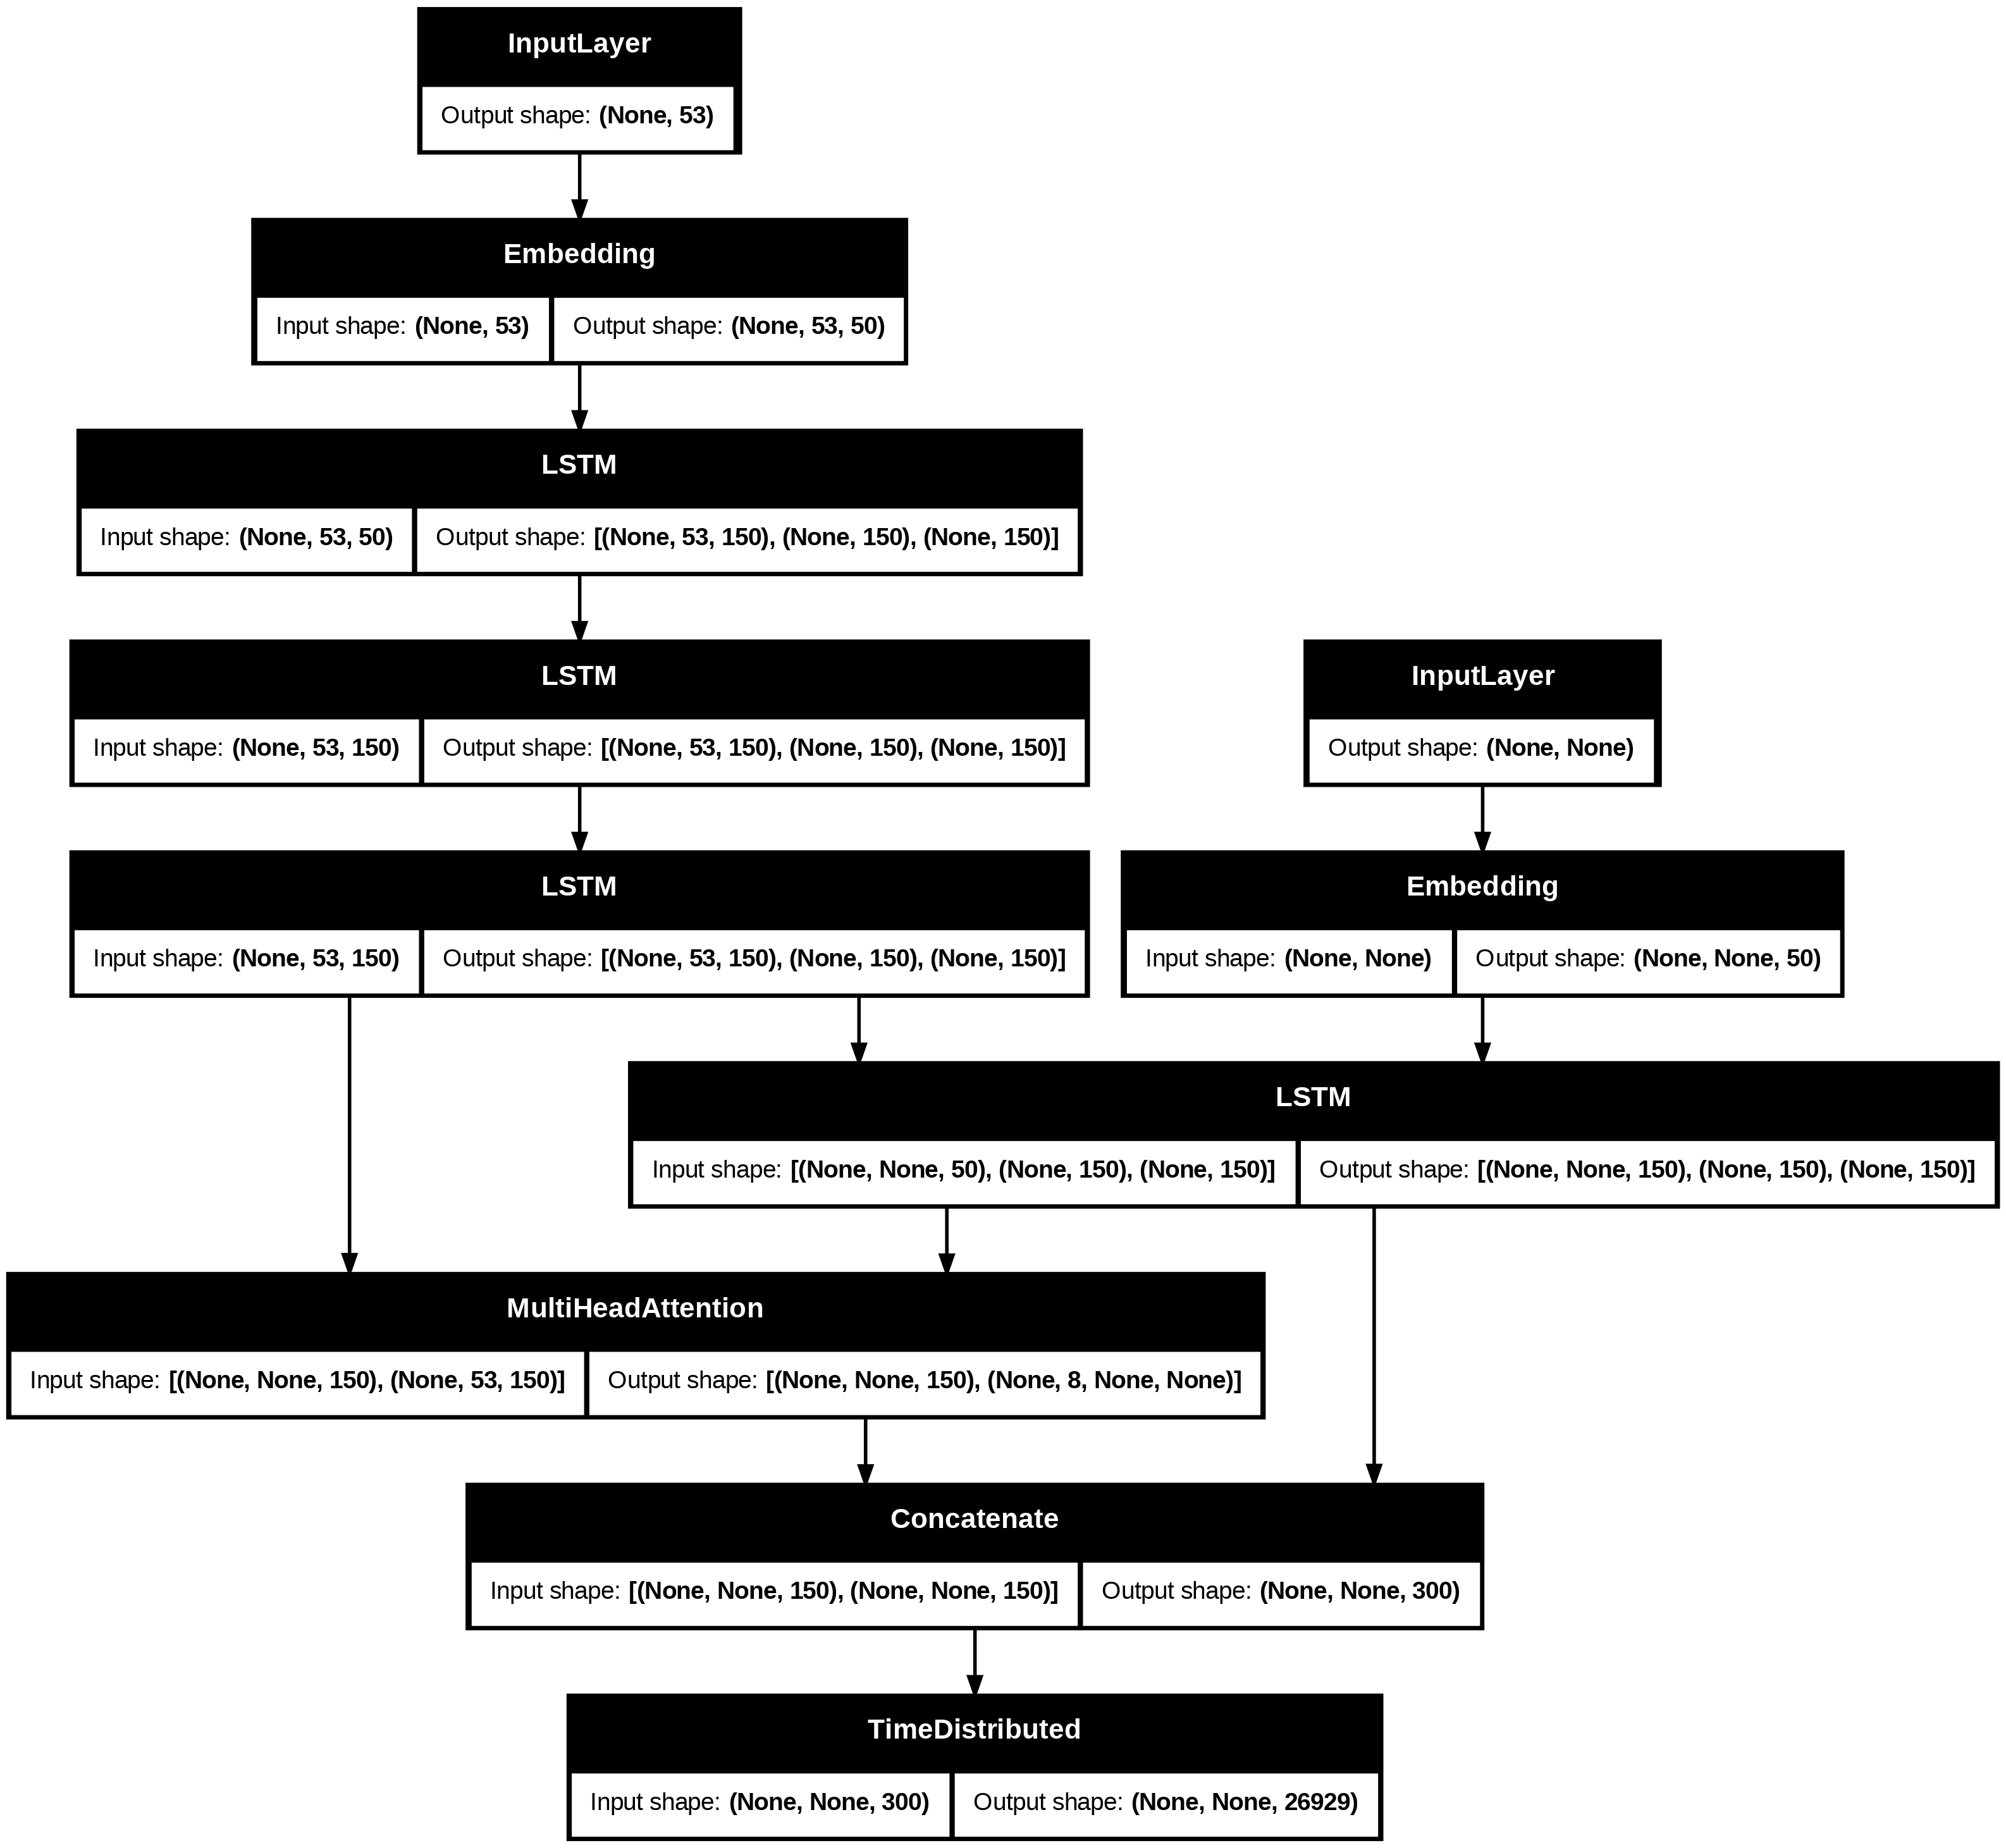

In [20]:
model_id = 2
plot_model(model, to_file=f'saved_model/model_id={model_id}/train_model1.png', show_shapes=True)

In [21]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
# callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1],1)[:,1:],
                    epochs=20,
                    callbacks=[es],
                    batch_size=64,
                    validation_data = ([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))


Epoch 1/20
2470/2470 ━━━━━━━━━━━━━━━━━━━━ 676s 268ms/step - accuracy: 0.8956 - loss: 0.9152 - val_accuracy: 0.8182 - val_loss: 1.2016
Epoch 2/20
2470/2470 ━━━━━━━━━━━━━━━━━━━━ 676s 269ms/step - accuracy: 0.9081 - loss: 0.6085 - val_accuracy: 0.8292 - val_loss: 1.0967
Epoch 3/20
2470/2470 ━━━━━━━━━━━━━━━━━━━━ 682s 268ms/step - accuracy: 0.9127 - loss: 0.5559 - val_accuracy: 0.8344 - val_loss: 1.0184
Epoch 4/20
2470/2470 ━━━━━━━━━━━━━━━━━━━━ 663s 268ms/step - accuracy: 0.9163 - loss: 0.5141 - val_accuracy: 0.8410 - val_loss: 0.9560
Epoch 5/20
2470/2470 ━━━━━━━━━━━━━━━━━━━━ 682s 268ms/step - accuracy: 0.9198 - loss: 0.4786 - val_accuracy: 0.8471 - val_loss: 0.8929
Epoch 6/20
2470/2470 ━━━━━━━━━━━━━━━━━━━━ 682s 268ms/step - accuracy: 0.9229 - loss: 0.4496 - val_accuracy: 0.8542 - val_loss: 0.8431
Epoch 7/20
2470/2470 ━━━━━━━━━━━━━━━━━━━━ 683s 269ms/step - accuracy: 0.9267 - loss: 0.4195 - val_accuracy: 0.8613 - val_loss: 0.7884
Epoch 8/20
2470/2470 ━━━━━━━━━━━━━━━━━━━━ 686s 270ms/step - ac

In [22]:
# save model

base_path = f"/content/drive/MyDrive/Machine_Translation/saved_model/model_id={model_id}/"
model_name = f"NMT_model{model_id}.json"
model_weights = f"NMT_model_weight{model_id}.weights.h5"
model_json = model.to_json()
with open(base_path+model_name, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(base_path+model_weights)
print("Saved model to disk")

Saved model to disk


In [ ]:
# loading the model architecture and asigning the weights
json_file = open(base_path+model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json)
# load weights into new model
model_loaded.load_weights(base_path+model_weights)

In [23]:
## this is just to load old model - #TODO
# loading the model architecture and asigning the weights
json_file = open('/content/drive/MyDrive/Machine_Translation/saved_model/NMT_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json)
# load weights into new model
model_loaded.load_weights('/content/drive/MyDrive/Machine_Translation/saved_model/NMT_model_weight.weights.h5')

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:

with open('data_pkl/NMT_Etokenizer.pkl','rb') as f:
  vocab_size_source, Eword2index, englishTokenizer = pkl.load(f)

with open('data_pkl/NMT_Mtokenizer.pkl', 'rb') as f:
  vocab_size_target, Mword2index, marathiTokenizer = pkl.load(f)

with open('data_pkl/NMT_data.pkl','rb') as f:
  X_train, y_train, X_test, y_test = pkl.load(f)

In [25]:
Eindex2word = englishTokenizer.index_word
Findex2word = frenchTokenizer.index_word

In [26]:
model_loaded.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 53)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 53, 50)         │        696,500 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 53, 50),       │         20,200 │ embedding[0][0]        │
│                           │ (None, 50), (None,     │                │                        │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 53, 50),       │         20,200 │ lstm[0][0]             │
│                           │ (None, 50), (None,     │                │                        │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 50)       │      1,345,300 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 53, 50),       │         20,200 │ lstm_1[0][0]           │
│                           │ (None, 50), (None,     │                │                        │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 50),     │         20,200 │ embedding_1[0][0],     │
│                           │ (None, 50), (None,     │                │ lstm_2[0][1],          │
│                           │ 50)]                   │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ [(None, None, 50),     │         81,250 │ lstm_3[0][0],          │
│ (MultiHeadAttention)      │ (None, 8, None, None)] │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 100)      │              0 │ lstm_3[0][0],          │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 26906)    │      2,717,506 │ concatenate[0][0]      │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,842,714 (37.55 MB)

 Trainable params: 4,921,356 (18.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,921,358 (18.77 MB)

In [27]:
# latent_dim=50
encoder_model, decoder_model = decoder_inference(model_loaded,latent_dim)

(None, 53, 50)
(None, None)


In [28]:
for i in range(10):
  print("Review:",source_sequence(X_test[i],Eindex2word))
  print("Original summary:",target_sequence(y_test[i],Fword2index,Findex2word))
  print("Predicted summary:",decode_sequence(encoder_model,Fword2index,decoder_model,X_test[i].reshape(1,53),Findex2word))
  print("\n")

Review: start can i talk to you for a minute end 
Original summary: je peux te parler une japonais 
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted summary:  je ne veux pas que tu veux que tu veux etre


Review: start youre opportunistic end 
Original summary: vous etes un mapprete 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/st